# Importing Librariesa

In [23]:
!pip install -q evaluate rouge-score

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import json
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model, TaskType
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
import time
import torch
from  evaluate import load
from sentence_transformers import SentenceTransformer, util
import re
from google.colab import drive


# Modeling

In [25]:
# Loading a single JSONL file generated after data processing

data_files = {
    "train": "/content/train.jsonl",
    "test": "/content/test.jsonl",
    "val": "/content/val.jsonl"
}

raw_datasets = load_dataset("json", data_files=data_files)

train_dataset = raw_datasets["train"]
test_dataset = raw_datasets["test"]
val_dataset = raw_datasets["val"]

print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 5781
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 721
    })
    val: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 725
    })
})


In [26]:
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype="auto", device_map="auto")
model.config.pad_token_id = tokenizer.pad_token_id


In [27]:
if hasattr(model, 'generation_config') and model.generation_config is not None:
    print("Values from model.generation_config:")
    print(model.generation_config)

    max_new_tokens = getattr(model.generation_config, "max_new_tokens", "Not set")
    num_return_sequences = getattr(model.generation_config, "num_return_sequences", "Not set")

    print(f"\nmax_new_tokens: {max_new_tokens}")
    print(f"num_return_sequences: {num_return_sequences}")
    print(f"temperature: {model.generation_config.temperature}")
    print(f"top_p: {model.generation_config.top_p}")

else:
    print("Model does not have a generation_config or it is not set.")

Values from model.generation_config:
GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 2,
  "max_length": 2048,
  "pad_token_id": 0
}


max_new_tokens: None
num_return_sequences: 1
temperature: 1.0
top_p: 1.0


In [28]:
# Tokenizing data

def tokenize(example):
    prompt = f"{example['instruction']}\nInput: {example['input']}\nOutput:"
    target = example['output']
    return tokenizer(
        prompt,
        text_target=target,
        truncation=True,
        padding="max_length",    # Ensures each input-output pair fits within 512 tokens.
        max_length=512,
    )

tokenized_train_dataset = train_dataset.map(tokenize,batched=False,remove_columns=train_dataset.column_names)
tokenized_val_dataset = val_dataset.map(tokenize,batched=False,remove_columns=val_dataset.column_names)
tokenized_test_dataset = test_dataset.map(tokenize,batched=False,remove_columns=test_dataset.column_names)


Map:   0%|          | 0/5781 [00:00<?, ? examples/s]

Map:   0%|          | 0/725 [00:00<?, ? examples/s]

Map:   0%|          | 0/721 [00:00<?, ? examples/s]

In [29]:

lora_config = LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],   # Lora application on 4 layers
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 1,126,400 || all params: 1,101,174,784 || trainable%: 0.1023


In [30]:


training_args = TrainingArguments(
    output_dir="/content/tinyllama_aws_faq_model",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=0.5,
    eval_strategy="steps",
    eval_steps=10,
    logging_strategy="steps",
    logging_first_step=True,
    logging_steps=10,
    learning_rate=2e-4,
    fp16=True,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,   #  fine-tuning
    eval_dataset=tokenized_val_dataset,  # validation
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Start time
start_time = time.time()

# Track initial memory (if using GPU)
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    start_mem = torch.cuda.memory_allocated()
else:
    start_mem = 0

trainer.train()

# End time
end_time = time.time()

# Compute memory used
if torch.cuda.is_available():
    peak_mem = torch.cuda.max_memory_allocated()
    used_mem_MB = (peak_mem - start_mem) / (1024 ** 2)
else:
    used_mem_MB = 0

/tmp/ipython-input-3437497015.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
10,3.072500,2.298493
20,1.712200,1.443154
30,1.478200,1.421461
40,1.343700,1.409564
50,1.332600,1.396579
60,1.255100,1.396325
70,1.399400,1.387090
80,1.330200,1.388421
90,1.331300,1.382304
100,1.321200,1.376018


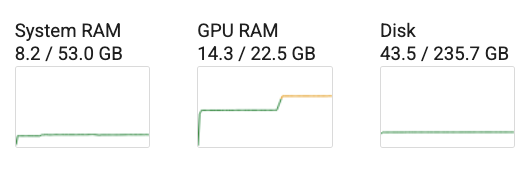

# Validation

In [45]:
# Training duration
training_time = end_time - start_time

# Print Resources used
print(f"🕒 Training Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"💾 Peak Model Training GPU Memory Used : {used_mem_MB:.2f} MB")

🕒 Training Time: 1439.14 seconds (23.99 minutes)
💾 Peak Model Training GPU Memory Used : 6684.81 MB


In [46]:
pd.DataFrame(trainer.state.log_history)[["step", "eval_loss"]].dropna().tail(10)


,step,eval_loss
54,270,1.334445
56,280,1.333681
58,290,1.332876
60,300,1.332024
62,310,1.331659
64,320,1.331226
66,330,1.330496
68,340,1.329756
70,350,1.329297
72,360,1.329131


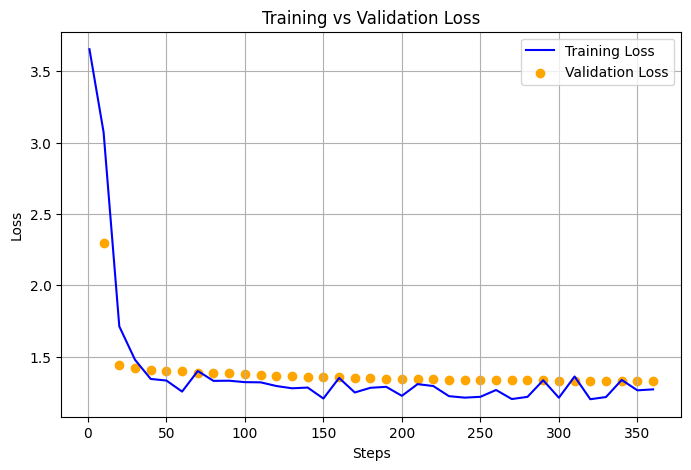

In [47]:
loss_df = pd.DataFrame(trainer.state.log_history)

plt.figure(figsize=(8, 5))

# Training loss logged continously
train_loss_df = loss_df.dropna(subset=["loss"])
plt.plot(train_loss_df["step"], train_loss_df["loss"], label="Training Loss", color="blue")

# Validation loss only at eval steps
eval_loss_df = loss_df.dropna(subset=["eval_loss"])
plt.scatter(eval_loss_df["step"], eval_loss_df["eval_loss"], label="Validation Loss", color="orange")


plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


# Evaluation

In [35]:

STOP_MARKERS = [
    "\nInput:", "\nUser:", "\nExplanation:", "\nTranscribed",
    "\nQuestion:", "\nQ:", "\nAnswer:", "\nOutput:"
]

def extract_answer(full_text: str) -> str:
    # Find the first "Output:" block
    m = re.search(r"Output:\s*(.*)", full_text, flags=re.DOTALL)
    ans = m.group(1).strip() if m else full_text.strip()

    # Cut at earliest stop marker (if any)
    cut_idx = len(ans)
    for marker in STOP_MARKERS:
        i = ans.find(marker)
        if i != -1:
            cut_idx = min(cut_idx, i)
    return ans[:cut_idx].strip()


In [44]:
# Evaluating only first 213 test samples out of 725 for faster evaluation
test_samples = test_dataset.select(range(213))

# Load metrics
rouge = load("rouge")
bleu = load("bleu")
sbert = SentenceTransformer("all-MiniLM-L6-v2")

# Ensuring model is in evaluation mode
model.eval()

predictions = []
references = []
questions = []
actual_answers = []
generated_answers = []

for example in test_samples:
    prompt = f"{example['instruction']}\nInput: {example['input']}\nOutput:"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to("cuda")

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=100)

    full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Use the extract_answer function to get the cleaned answer
    generated_answer = extract_answer(full_text)

    predictions.append(generated_answer)
    references.append(example["output"])
    questions.append(example["input"])
    actual_answers.append(example["output"])
    generated_answers.append(generated_answer)


# Compute metrics
bleu_score = bleu.compute(predictions=predictions, references=references)
rouge_score = rouge.compute(predictions=predictions, references=references)
semantic_sim = [util.cos_sim(sbert.encode(p), sbert.encode(r)).item() for p, r in zip(predictions, references)]

# Print Results
print("🔍 BLEU:", bleu_score["bleu"])
print("🔍 ROUGE:", rouge_score)
print("🔍 SBERT Semantic Similarity (avg):", np.mean(semantic_sim))


# Export to Excel
output_df = pd.DataFrame({
    'Question': questions,
    'Actual Answer': actual_answers,
    'Generated Answer': generated_answers
})

output_excel_path = "/content/TinyLlama_Model2_generated_answers.xlsx"
output_df.to_excel(output_excel_path, index=False)
print(f"Results saved to {output_excel_path}")

🔍 BLEU: 0.011584499242020315
🔍 ROUGE: {'rouge1': np.float64(0.2462620723690849), 'rouge2': np.float64(0.09026845902889186), 'rougeL': np.float64(0.19000662934810894), 'rougeLsum': np.float64(0.19165458715176442)}
🔍 SBERT Semantic Similarity (avg): 0.7069920648431554
Results saved to /content/TinyLlama_Model2_generated_answers.xlsx


In [37]:

# OPTIONAL: If using Google Drive

from google.colab import drive
drive.mount('/content/drive')
model.save_pretrained("/content/drive/MyDrive/Tinyllama_Model")
tokenizer.save_pretrained("/content/drive/MyDrive/Tinyllama_Model")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


('/content/drive/MyDrive/Tinyllama_Model/tokenizer_config.json',
 '/content/drive/MyDrive/Tinyllama_Model/special_tokens_map.json',
 '/content/drive/MyDrive/Tinyllama_Model/chat_template.jinja',
 '/content/drive/MyDrive/Tinyllama_Model/tokenizer.model',
 '/content/drive/MyDrive/Tinyllama_Model/added_tokens.json',
 '/content/drive/MyDrive/Tinyllama_Model/tokenizer.json')

In [48]:

from transformers import AutoModelForCausalLM, AutoTokenizer

drive_path = "/content/drive/MyDrive/Tinyllama_Model"

model = AutoModelForCausalLM.from_pretrained(drive_path, torch_dtype="auto", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(drive_path, trust_remote_code=True)


In [49]:
# Display the first 100 samples from the test dataset
print(test_dataset.select(range(100)))

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 100
})


# Testing on user query

In [51]:
question = "What are Amazon EC2 A1 instances??"
input_text = f"Answer the following AWS-related question.\nInput: {question}\nOutput:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs,max_new_tokens=100)
full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
answer = extract_answer(full_text)
print(answer)

Amazon EC2 A1 instances are a new instance type that provides a 10% performance improvement over Amazon EC2 A1.0 instances.


In [52]:
question = "What is Savings Plans and their types"
input_text = f"Answer the following AWS-related question.\nInput: {question}\nOutput:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=100)
full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
answer = extract_answer(full_text)
print(answer)

Savings Plans are a way to save money on AWS services. They are a way to reduce your monthly costs by using AWS services that are not currently in use.
